In [3]:
print("Test")

Test


In [15]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection


def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    def draw_poly_patch(self):
        # rotate theta such that the first axis is at the top
        verts = unit_poly_verts(theta + np.pi / 2)
        return plt.Polygon(verts, closed=True, edgecolor='k')

    def draw_circle_patch(self):
        # unit circle centered on (0.5, 0.5)
        return plt.Circle((0.5, 0.5), 0.5)

    patch_dict = {'polygon': draw_poly_patch, 'circle': draw_circle_patch}
    if frame not in patch_dict:
        raise ValueError('unknown value for `frame`: %s' % frame)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1
        # define draw_frame method
        draw_patch = patch_dict[frame]

        def __init__(self, *args, **kwargs):
            super(RadarAxes, self).__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, **kwargs):
            """Override fill so that line is closed by default"""
            closed = kwargs.pop('closed', True)
            return super(RadarAxes, self).fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super(RadarAxes, self).plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            return self.draw_patch()

        def _gen_axes_spines(self):
            if frame == 'circle':
                return PolarAxes._gen_axes_spines(self)
            # The following is a hack to get the spines (i.e. the axes frame)
            # to draw correctly for a polygon frame.

            # spine_type must be 'left', 'right', 'top', 'bottom', or `circle`.
            spine_type = 'circle'
            verts = unit_poly_verts(theta + np.pi / 2)
            # close off polygon by repeating first vertex
            verts.append(verts[0])
            path = Path(verts)

            spine = Spine(self, spine_type, path)
            spine.set_transform(self.transAxes)
            return {'polar': spine}

    register_projection(RadarAxes)
    return theta


def unit_poly_verts(theta):
    """Return vertices of polygon for subplot axes.

    This polygon is circumscribed by a unit circle centered at (0.5, 0.5)
    """
    x0, y0, r = [0.5] * 3
    verts = [(r*np.cos(t) + x0, r*np.sin(t) + y0) for t in theta]
    return verts


def example_data():
    # The following data is from the Denver Aerosol Sources and Health study.
    # See  doi:10.1016/j.atmosenv.2008.12.017
    #
    # The data are pollution source profile estimates for five modeled
    # pollution sources (e.g., cars, wood-burning, etc) that emit 7-9 chemical
    # species. The radar charts are experimented with here to see if we can
    # nicely visualize how the modeled source profiles change across four
    # scenarios:
    #  1) No gas-phase species present, just seven particulate counts on
    #     Sulfate
    #     Nitrate
    #     Elemental Carbon (EC)
    #     Organic Carbon fraction 1 (OC)
    #     Organic Carbon fraction 2 (OC2)
    #     Organic Carbon fraction 3 (OC3)
    #     Pyrolized Organic Carbon (OP)
    #  2)Inclusion of gas-phase specie carbon monoxide (CO)
    #  3)Inclusion of gas-phase specie ozone (O3).
    #  4)Inclusion of both gas-phase species is present...
    data = [
        ['Sulfate', 'Nitrate', 'EC', 'OC1', 'OC2', 'OC3', 'OP', 'CO', 'O3'],
        ('Basecase', [
            [0.88, 0.01, 0.03, 0.03, 0.00, 0.06, 0.01, 0.00, 0.00],
            [0.07, 0.95, 0.04, 0.05, 0.00, 0.02, 0.01, 0.00, 0.00],
            [0.01, 0.02, 0.85, 0.19, 0.05, 0.10, 0.00, 0.00, 0.00],
            [0.02, 0.01, 0.07, 0.01, 0.21, 0.12, 0.98, 0.00, 0.00],
            [0.01, 0.01, 0.02, 0.71, 0.74, 0.70, 0.00, 0.00, 0.00]]),
        ('With CO', [
            [0.88, 0.02, 0.02, 0.02, 0.00, 0.05, 0.00, 0.05, 0.00],
            [0.08, 0.94, 0.04, 0.02, 0.00, 0.01, 0.12, 0.04, 0.00],
            [0.01, 0.01, 0.79, 0.10, 0.00, 0.05, 0.00, 0.31, 0.00],
            [0.00, 0.02, 0.03, 0.38, 0.31, 0.31, 0.00, 0.59, 0.00],
            [0.02, 0.02, 0.11, 0.47, 0.69, 0.58, 0.88, 0.00, 0.00]]),
        ('With O3', [
            [0.89, 0.01, 0.07, 0.00, 0.00, 0.05, 0.00, 0.00, 0.03],
            [0.07, 0.95, 0.05, 0.04, 0.00, 0.02, 0.12, 0.00, 0.00],
            [0.01, 0.02, 0.86, 0.27, 0.16, 0.19, 0.00, 0.00, 0.00],
            [0.01, 0.03, 0.00, 0.32, 0.29, 0.27, 0.00, 0.00, 0.95],
            [0.02, 0.00, 0.03, 0.37, 0.56, 0.47, 0.87, 0.00, 0.00]]),
        ('CO & O3', [
            [0.87, 0.01, 0.08, 0.00, 0.00, 0.04, 0.00, 0.00, 0.01],
            [0.09, 0.95, 0.02, 0.03, 0.00, 0.01, 0.13, 0.06, 0.00],
            [0.01, 0.02, 0.71, 0.24, 0.13, 0.16, 0.00, 0.50, 0.00],
            [0.01, 0.03, 0.00, 0.28, 0.24, 0.23, 0.00, 0.44, 0.88],
            [0.02, 0.00, 0.18, 0.45, 0.64, 0.55, 0.86, 0.00, 0.16]])
    ]
    return data


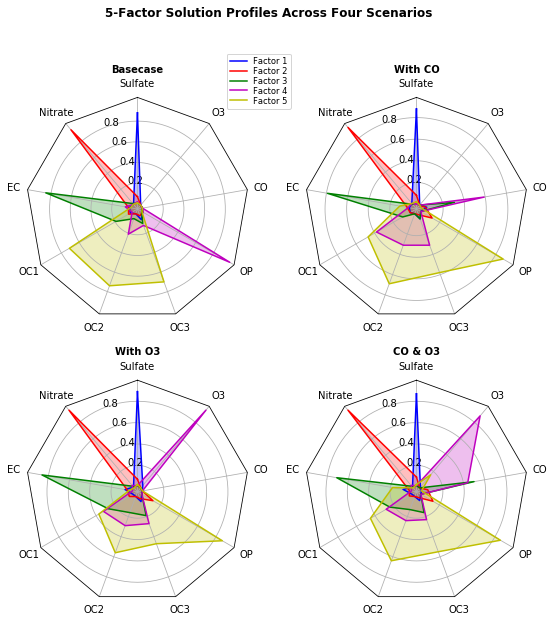

In [19]:
N = 9
theta = radar_factory(N, frame='polygon')

data = example_data()
spoke_labels = data.pop(0)

fig, axes = plt.subplots(figsize=(9, 9), nrows=2, ncols=2,
                         subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

colors = ['b', 'r', 'g', 'm', 'y']
# Plot the four cases from the example data on separate axes
for ax, (title, case_data) in zip(axes.flatten(), data):
    ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                 horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.25)
    ax.set_varlabels(spoke_labels)

# add legend relative to top-left plot

ax = axes[0, 0]
labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
legend = ax.legend(labels, loc=(0.9, .95),
                   labelspacing=0.1, fontsize='small')

fig.text(0.5, 0.965, '5-Factor Solution Profiles Across Four Scenarios',
         horizontalalignment='center', color='black', weight='bold',
         size='large')

plt.show()

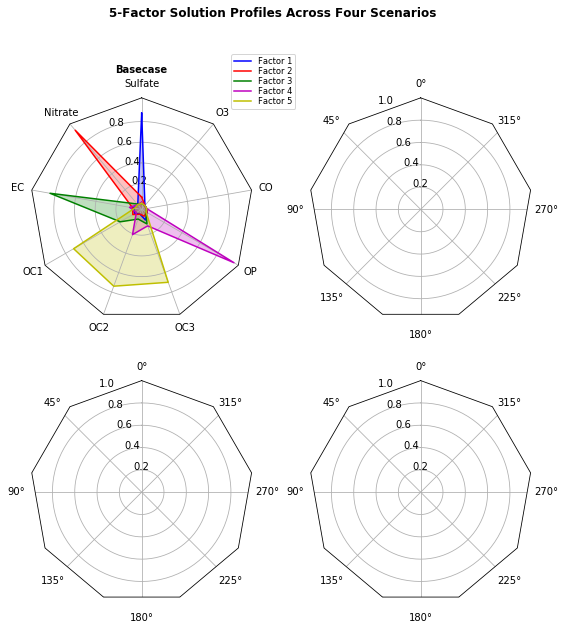

In [34]:
def example_data():
    # The following data is from the Denver Aerosol Sources and Health study.
    # See  doi:10.1016/j.atmosenv.2008.12.017
    #
    # The data are pollution source profile estimates for five modeled
    # pollution sources (e.g., cars, wood-burning, etc) that emit 7-9 chemical
    # species. The radar charts are experimented with here to see if we can
    # nicely visualize how the modeled source profiles change across four
    # scenarios:
    #  1) No gas-phase species present, just seven particulate counts on
    #     Sulfate
    #     Nitrate
    #     Elemental Carbon (EC)
    #     Organic Carbon fraction 1 (OC)
    #     Organic Carbon fraction 2 (OC2)
    #     Organic Carbon fraction 3 (OC3)
    #     Pyrolized Organic Carbon (OP)
    #  2)Inclusion of gas-phase specie carbon monoxide (CO)
    #  3)Inclusion of gas-phase specie ozone (O3).
    #  4)Inclusion of both gas-phase species is present...
    data = [
        ['Sulfate', 'Nitrate', 'EC', 'OC1', 'OC2', 'OC3', 'OP', 'CO', 'O3'],
        ('Basecase', [
            [0.88, 0.01, 0.03, 0.03, 0.00, 0.06, 0.01, 0.00, 0.00],
            [0.07, 0.95, 0.04, 0.05, 0.00, 0.02, 0.01, 0.00, 0.00],
            [0.01, 0.02, 0.85, 0.19, 0.05, 0.10, 0.00, 0.00, 0.00],
            [0.02, 0.01, 0.07, 0.01, 0.21, 0.12, 0.98, 0.00, 0.00],
            [0.01, 0.01, 0.02, 0.71, 0.74, 0.70, 0.00, 0.00, 0.00]])
    ]
    return data


N = 9
theta = radar_factory(N, frame='polygon')

data = example_data()
spoke_labels = data.pop(0)

fig, axes = plt.subplots(figsize=(9, 9), nrows=2, ncols=2,
                         subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

colors = ['b', 'r', 'g', 'm', 'y']
# Plot the four cases from the example data on separate axes
for ax, (title, case_data) in zip(axes.flatten(), data):
    ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                 horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.25)
    ax.set_varlabels(spoke_labels)

# add legend relative to top-left plot

ax = axes[0, 0]
labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
legend = ax.legend(labels, loc=(0.9, .95),
                   labelspacing=0.1, fontsize='small')

fig.text(0.5, 0.965, '5-Factor Solution Profiles Across Four Scenarios',
         horizontalalignment='center', color='black', weight='bold',
         size='large')

plt.show()

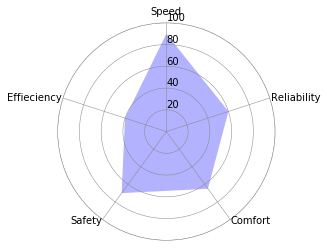

In [35]:
# Plots a radar chart.

from math import pi
import matplotlib.pyplot as plt


# Set data
cat = ['Speed', 'Reliability', 'Comfort', 'Safety', 'Effieciency']
values = [90, 60, 65, 70, 40]

N = len(cat)

x_as = [n / float(N) * 2 * pi for n in range(N)]

# Because our chart will be circular we need to append a copy of the first 
# value of each list at the end of each list with data
values += values[:1]
x_as += x_as[:1]


# Set color of axes
plt.rc('axes', linewidth=0.5, edgecolor="#888888")


# Create polar plot
ax = plt.subplot(111, polar=True)


# Set clockwise rotation. That is:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)


# Set position of y-labels
ax.set_rlabel_position(0)


# Set color and linestyle of grid
ax.xaxis.grid(True, color="#888888", linestyle='solid', linewidth=0.5)
ax.yaxis.grid(True, color="#888888", linestyle='solid', linewidth=0.5)


# Set number of radial axes and remove labels
plt.xticks(x_as[:-1], [])

# Set yticks
plt.yticks([20, 40, 60, 80, 100], ["20", "40", "60", "80", "100"])


# Plot data
ax.plot(x_as, values, linewidth=0, linestyle='solid', zorder=3)

# Fill area
ax.fill(x_as, values, 'b', alpha=0.3)


# Set axes limits
plt.ylim(0, 100)


# Draw ytick labels to make sure they fit properly
for i in range(N):
    angle_rad = i / float(N) * 2 * pi

    if angle_rad == 0:
        ha, distance_ax = "center", 10
    elif 0 < angle_rad < pi:
        ha, distance_ax = "left", 1
    elif angle_rad == pi:
        ha, distance_ax = "center", 1
    else:
        ha, distance_ax = "right", 1

    ax.text(angle_rad, 100 + distance_ax, cat[i], size=10, horizontalalignment=ha, verticalalignment="center")

# Show polar plot
plt.show()

['var1', 'var2', 'var3', 'var4', 'var5']


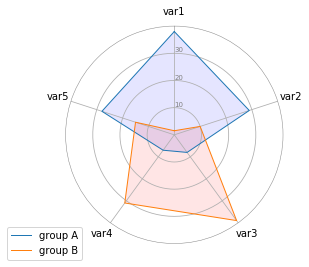

In [46]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi

# Set data
df = pd.DataFrame({
'group': ['A','B','C','D'],
'var1': [38, 1.5, 30, 4],
'var2': [29, 10, 9, 34],
'var3': [8, 39, 23, 24],
'var4': [7, 31, 33, 14],
'var5': [28, 15, 32, 14]
})



# ------- PART 1: Create background

# number of variable
categories=list(df)[1:]
print(categories)
N = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Initialise the spider plot
ax = plt.subplot(111, polar=True)

# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([10,20,30], ["10","20","30"], color="grey", size=7)
plt.ylim(0,40)


# ------- PART 2: Add plots

# Plot each individual = each line of the data
# I don't do a loop, because plotting more than 3 groups makes the chart unreadable

# Ind1
values=df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="group A")
ax.fill(angles, values, 'b', alpha=0.1)

# Ind2
values=df.loc[1].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="group B")
ax.fill(angles, values, 'r', alpha=0.1)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()

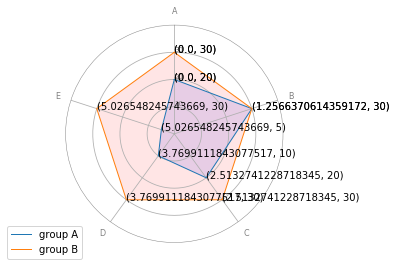

In [58]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi

# ------- PART 1: Create background

# number of variable
categories = ['A', 'B', 'C', 'D', 'E']
N = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Initialise the spider plot
ax = plt.subplot(111, polar=True)

# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, color='grey', size=8)

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([10,20,30], ["10","20","30"], color="grey", size=7)
plt.ylim(0,40)


# ------- PART 2: Add plots

# Plot each individual = each line of the data
# I don't do a loop, because plotting more than 3 groups makes the chart unreadable

# Ind1
values = [20, 30, 20, 10, 5]
values += values[:1]

ax.plot(angles, values, linewidth=1, linestyle='solid', label="group A")
ax.fill(angles, values, 'b', alpha=0.1)

for xy in zip(angles, values):                                       # <--
    ax.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

# Ind2

values = [30, 30, 30, 30, 30]
values += values[:1]

ax.plot(angles, values, linewidth=1, linestyle='solid', label="group B")
ax.fill(angles, values, 'r', alpha=0.1)

for xy in zip(angles, values):                                       # <--
    ax.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.show()

In [208]:
class SpiderPlot():
    def __init__(self, categories, data):
        self.categories = categories
        self.N = len(categories)
        self.data = data
        self.initial_data = np.array(data) # convert to matrix
        self.labels = self.initial_data
        self.w = 10
        self.h = 10
        self.min = 0.4
        
    def setSize(self, w, h):
        self.w = w
        self.h = h
        
    def preparePlot(self):

        # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
        self.angles = [n / float(self.N) * 2 * pi for n in range(self.N)]
        self.angles += angles[:1]

        # Initialise the spider plot
        fig = plt.figure(figsize=(self.w, self.h)) 
        ax = plt.subplot(111, polar=True)

        # If you want the first axis to be on top:
        ax.set_theta_offset(pi / 2)
        ax.set_theta_direction(-1)

        # Draw one axe per variable + add labels labels yet
        plt.xticks(angles[:-1], categories, color='grey', size=8)

        # Draw ylabels
        # @TODO
        ax.set_rlabel_position(0)
        #plt.yticks([0.4,0.6,0.8], ["10","20","30"], color="grey", size=7)
        plt.ylim(0,1)
    
        return ax
    
    def scaleData(self):
        self.scaled_data = np.zeros(self.initial_data.shape)
        
        #iterate over all axis
        for i in range(N):
            data = self.initial_data[:,i]
            
            OldMax = np.max(data)
            OldMin = np.min(data)
            OldRange = (OldMax - OldMin)  
            NewRange = (1 - self.min)  
            self.scaled_data[:,i] = (((data - OldMin) * NewRange) / OldRange) + self.min
        
    def plot(self):
        ax = self.preparePlot()
        
        #iterate over all data sets
        for i in range(len(self.data)):
            values = self.scaled_data[i,:].tolist()
            values += values[:1]
            
            ax.plot(self.angles, values, linewidth=1, linestyle='solid', label="group B")
            ax.fill(self.angles, values, alpha=0.1)
            
            # add labels
            for j, val in enumerate(values):
                if(j==len(values)-1):
                    break
                ax.annotate('%s' % self.labels[i,j], xy=(self.angles[j], val), textcoords='data', size=7)
            
        plt.show()    
        

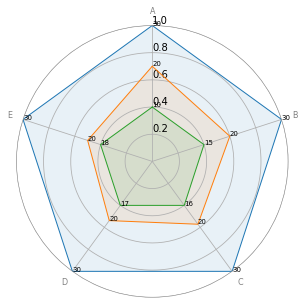

In [210]:
categories = ['A', 'B', 'C', 'D', 'E']
val1 = [30, 30, 30, 30, 30]
val2 = [20, 20, 20, 20, 20]
val3 = [10, 15, 16, 17, 18]
values = [val1, val2, val3]

mySpider = SpiderPlot(categories, values)
mySpider.setSize(5,5)
mySpider.scaleData()
mySpider.plot()

In [179]:
val1 = [30, 30, 30, 30, 30]
val2 = [15, 20, 20, 20, 20]
val3 = [10, 15, 16, 17, 18]
values = [val1, val2, val3]

initial_data = np.array(values)
print(np.zeros(initial_data.shape))
print(initial_data)
print('--')
initial_data[:,0] = initial_data[:,1]
print(initial_data)
axis = initial_data[:,0]
print(axis)
np.argmin(axis)

OldRange = (np.max(axis) - np.min(axis))  
NewRange = (1 - 0.4)  
NewValue = (((axis - np.min(axis)) * NewRange) / OldRange) + 0.4
print(NewValue)

[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
[[30 30 30 30 30]
 [15 20 20 20 20]
 [10 15 16 17 18]]
--
[[30 30 30 30 30]
 [20 20 20 20 20]
 [15 15 16 17 18]]
[30 20 15]
[ 1.   0.6  0.4]
